In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from keras.datasets import fashion_mnist 
from keras.layers import Dense, Flatten, Reshape 
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential 

In [2]:
rows = 28
cols = 28
channels = 1 
noise = 100

In [3]:
def generator(noise, rows, cols, channels):
    shape = (rows, cols, channels)
    model = Sequential()
    model.add(Dense(128, input_dim = noise))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense((rows*cols*channels), activation = 'tanh'))
    model.add(Reshape(shape))
    return model

In [4]:
def discriminator(rows, cols, channels):
    shape = (rows, cols, channels)
    model = Sequential()
    model.add(Flatten(input_shape = shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [5]:
def gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
generator = generator(noise, rows, cols, channels)
discriminator = discriminator(rows, cols, channels)
discriminator.compile(loss = 'binary_crossentropy', 
                     optimizer = Adam(),
                     metrics = ['accuracy'])
discriminator.trainable = False
gan = gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

In [7]:
check_points = []
loss = []
accuracy = []

In [8]:
def train(iterations, sample_interval, batch_size):
    
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(iterations):

        idt = np.random.randint(0, X_train.shape[0], batch_size)
        true_images = X_train[idt]

        idf = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(idf)

        disc_loss_true = discriminator.train_on_batch(true_images, true)
        disc_loss_fake = discriminator.train_on_batch(fake_images, fake)
        disc_loss, tot_accuracy = 0.5 * np.add(disc_loss_true, disc_loss_fake)

        idf = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(idf)

        gen_loss = gan.train_on_batch(idf, true)

        if (i + 1) % sample_interval == 0:

            loss.append((disc_loss, gen_loss))
            accuracy.append(100.0 * tot_accuracy)
            check_points.append(i + 1)

            print("%d [Discriminator loss: %f, accuracy.: %.2f%%] [Generator loss: %f]" %
                  (i + 1, disc_loss, 100.0 * tot_accuracy, gen_loss))
            
            display_images(generator, noise)

In [9]:
def display_images(generator, noise, grid_rows=4, grid_cols=4):

    n = np.random.normal(0, 1, (grid_rows * grid_cols, noise))
    images = generator.predict(n)
    images = 0.5 * images + 0.5

    fig, axs = plt.subplots(grid_rows,
                            grid_cols,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    count = 0
    for i in range(grid_rows):
        for j in range(grid_cols):
            axs[i, j].imshow(images[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1

20 [Discriminator loss: 0.005368, accuracy.: 100.00%] [Generator loss: 6.987489]
40 [Discriminator loss: 0.014092, accuracy.: 100.00%] [Generator loss: 6.488733]
60 [Discriminator loss: 0.016763, accuracy.: 100.00%] [Generator loss: 5.499393]
80 [Discriminator loss: 0.020194, accuracy.: 100.00%] [Generator loss: 4.487771]
100 [Discriminator loss: 0.068542, accuracy.: 100.00%] [Generator loss: 2.760685]
120 [Discriminator loss: 0.101254, accuracy.: 100.00%] [Generator loss: 2.029460]
140 [Discriminator loss: 0.044506, accuracy.: 100.00%] [Generator loss: 2.658831]
160 [Discriminator loss: 0.046518, accuracy.: 100.00%] [Generator loss: 2.567867]


KeyboardInterrupt: 

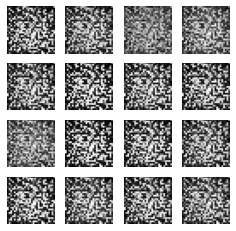

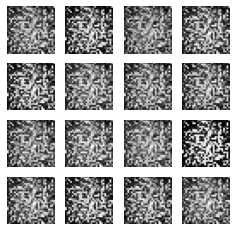

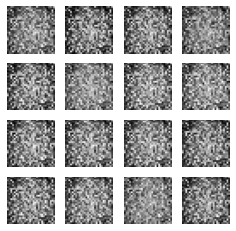

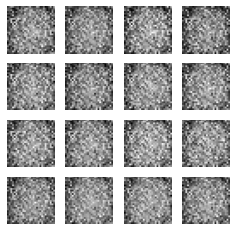

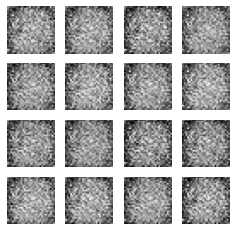

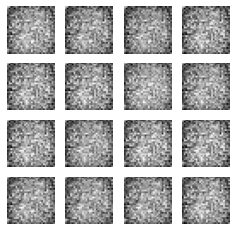

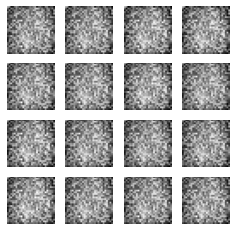

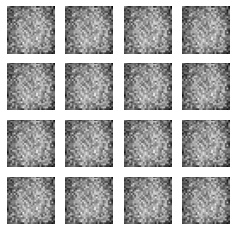

In [11]:
iterations = 1000
sample_interval = 100
batch_size = 128

train(iterations, sample_interval, batch_size)